## Network Characterization

In [246]:
'''
Created on 2023-10-25 12:51:32
@author: caitgrasso
'''

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import cv2
import matplotlib as mpl
from collections import Counter
from scipy.stats import linregress

### Load data

In [247]:
BOT = 'bot_02'

# Load FC matrices
fc_before = np.loadtxt('../network_inference_data/fc_matrices/{}_before_mimat_w_pruned.csv'.format(BOT), delimiter=',')
fc_after = np.loadtxt('../network_inference_data/fc_matrices/{}_after_mimat_w_pruned.csv'.format(BOT), delimiter=',')

# Load spatial data
com_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_centroids_pruned.csv'.format(BOT), header=0)
com_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_centroids_pruned.csv'.format(BOT), header=0)

pixels_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_pixels_pruned.csv'.format(BOT), header=0)
pixels_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_pixels_pruned.csv'.format(BOT), header=0)

# Load  bot images
img_before = cv2.imread(f'../bot_images/{BOT}_before_00001.tiff')
img_after = cv2.imread(f'../bot_images/{BOT}_after_00001.tiff')

In [248]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif'})

### Segmentation of nodes included in the network

Before

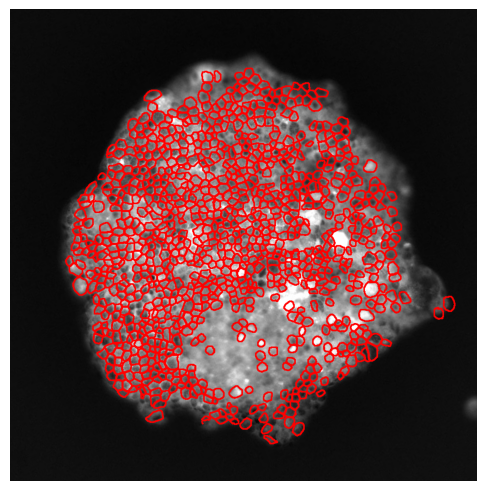

In [249]:
labels = np.unique(pixels_df_before['label'])

# Draw contours

# Note: (0,0) in OpenCV is top left. (0,0) in matplotlib is bottom left

contour_img = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)

for i in labels:
    xs = list(pixels_df_before[pixels_df_before['label']==i]['x'])
    ys = list(pixels_df_before[pixels_df_before['label']==i]['y'])

    mask = np.zeros(contour_img.shape, dtype=int)
    mask[xs,ys]=1
    
    if np.sum(mask) > 0:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img_before, contours, -1, (255, 0, 0), 2)

fig,ax = plt.subplots(layout='constrained')
ax.imshow(img_before)
bbox_before = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_before_segmentation.png', dpi=300, bbox_inches='tight')

After

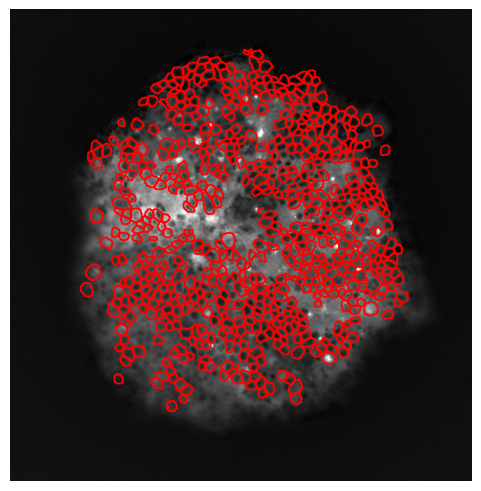

In [250]:
labels = np.unique(pixels_df_after['label'])

# Draw contours

contour_img = cv2.cvtColor(img_after, cv2.COLOR_BGR2GRAY)

for i in labels:
    xs = list(pixels_df_after[pixels_df_after['label']==i]['x'])
    ys = list(pixels_df_after[pixels_df_after['label']==i]['y'])

    mask = np.zeros(contour_img.shape, dtype=int)
    mask[xs,ys]=1
    
    if np.sum(mask) > 0:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img_after, contours, -1, (255, 0, 0), 2)

fig,ax = plt.subplots(layout='constrained')
ax.imshow(img_after)
bbox_after = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_after_segmentation.png', dpi=300, bbox_inches='tight')

### Visualize networks

In [251]:
def plot_edges(ax, mat, com_df, color=(0,0,1,0.6)):
    mat_vals = mat[np.triu_indices(mat.shape[0],k=1)]
    mat_edges_r,mat_edges_c = np.triu_indices(mat.shape[0],k=1)

    for i in range(len(mat_vals)):
        val = mat_vals[i]
        nodei_id = mat_edges_r[i]
        nodej_id = mat_edges_c[i]

        x1 = com_df.iloc[nodei_id]["y"]      
        y1 = com_df.iloc[nodei_id]["x"]      
        
        x2 = com_df.iloc[nodej_id]["y"]      
        y2 = com_df.iloc[nodej_id]["x"]  

        ax.plot([x1,x2],[y1,y2], c=color, linewidth=val)  

In [252]:
NODE_COLOR = 'red'
EDGE_COLOR = (0,0,1,0.6)

Before

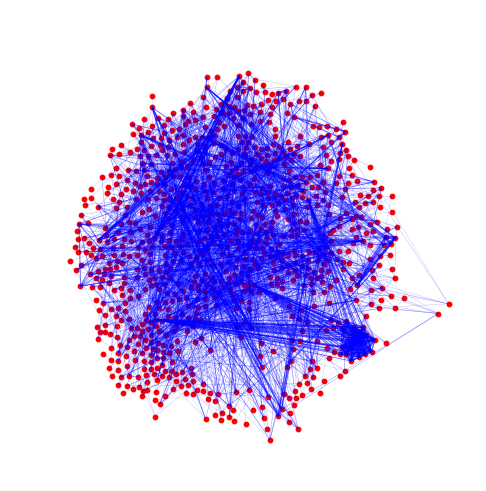

In [253]:
# Plot nodes 

fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_before.shape[0], img_before.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_before["y"], com_df_before["x"], c=NODE_COLOR, s=10)
plot_edges(ax, fc_before, com_df_before, color=EDGE_COLOR)

plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_before_network.png', dpi=300, bbox_inches='tight')
plt.show()

After

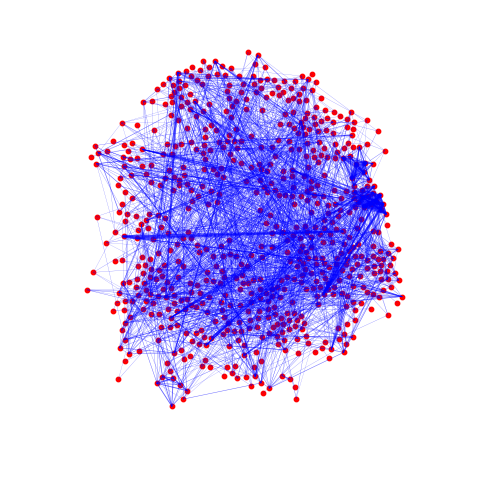

In [254]:
# Plot nodes 

fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_after.shape[0], img_after.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_after["y"], com_df_after["x"], c=NODE_COLOR, s=10)
plot_edges(ax, fc_after, com_df_after, color=EDGE_COLOR)

plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_after_network.png', dpi=300, bbox_inches='tight')
plt.show()

### Number of nodes and edges

In [255]:
node_dict = {'before':[],'after':[]}
edge_dict = {'before':[],'after':[]}
BOTS = ['bot_01', 'bot_02', 'bot_03', 'bot_04', 'bot_05', 'bot_06']

for bot in BOTS:

    for phase in ['before','after']:

        fc = np.loadtxt('../network_inference_data/fc_matrices/{}_{}_mimat_w_pruned.csv'.format(bot, phase), delimiter=',')

        nodes = fc.shape[0] 
        edges = np.sum(fc[np.triu_indices(fc.shape[0],k=1)]>0)

        node_dict[phase].append(nodes)
        edge_dict[phase].append(edges)

Nodes

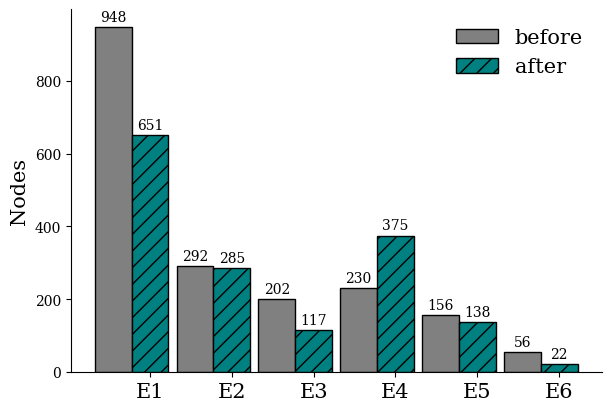

In [256]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

x = np.arange(len(BOTS))

width = 0.45
multiplier = 0

for label, val in node_dict.items():

    offset = width*multiplier
    # rects = ax.bar(x+offset, val, width, label=label)
    if label =='after':
        rects = ax.bar(x+offset, val, width, label=label, color='teal', edgecolor='k', hatch='//')
    else:
        rects = ax.bar(x+offset, val, width, label=label, color='gray', edgecolor='k')

    ax.bar_label(rects, padding=2)
    multiplier+=1

ax.set_ylabel('Nodes', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

ax.set_xticks(x + width, ['E1','E2','E3','E4','E5','E6'], fontsize=15)
ax.legend(loc='upper right', fontsize=15, frameon=False)

plt.savefig('../network_characterization_plots/nodes.png', dpi=300, bbox_inches='tight')


Edges

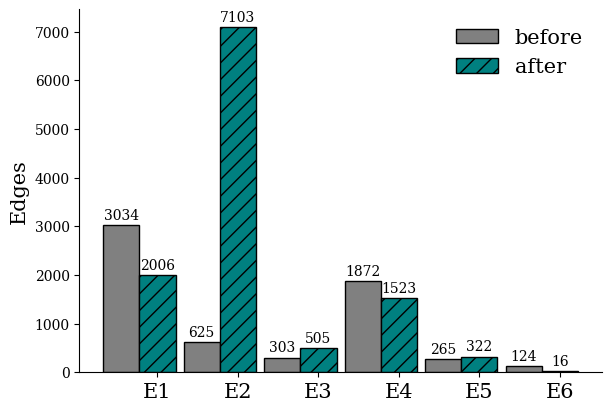

In [257]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

x = np.arange(len(BOTS))

width = 0.45
multiplier = 0

for label, val in edge_dict.items():

    offset = width*multiplier
    # rects = ax.bar(x+offset, val, width, label=label)
    if label =='after':
        rects = ax.bar(x+offset, val, width, label=label, color='teal', edgecolor='k', hatch='//')
    else:
        rects = ax.bar(x+offset, val, width, label=label, color='gray', edgecolor='k')

    ax.bar_label(rects, padding=2)
    multiplier+=1

ax.set_ylabel('Edges', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

ax.set_xticks(x + width, ['E1','E2','E3','E4','E5','E6'], fontsize=15)
ax.legend(loc='upper right', fontsize=15, frameon=False)

plt.savefig('../network_characterization_plots/edges.png', dpi=300, bbox_inches='tight')

### Degree Distributions

In [258]:
# Load degree distribution and null distribution
degdist_before = np.loadtxt(f'../network_analysis_data/degree_distributions/{BOT}_before_degree_distribution.csv', delimiter=',')
null_degdist_before = np.loadtxt(f'../network_analysis_data/null_degree_distributions/{BOT}_before.csv', delimiter=',')

degdist_after = np.loadtxt(f'../network_analysis_data/degree_distributions/{BOT}_after_degree_distribution.csv', delimiter=',')
null_degdist_after = np.loadtxt(f'../network_analysis_data/null_degree_distributions/{BOT}_after.csv', delimiter=',')

In [259]:
# Remove zeros - don't include disconnected nodes
# TODO: is this valid????
# TODO: instead fix the null distributions 

degdist_before = degdist_before[degdist_before!=0]
null_degdist_before = null_degdist_before[null_degdist_before!=0]

degdist_after = degdist_after[degdist_after!=0]
null_degdist_after = null_degdist_after[null_degdist_after!=0]


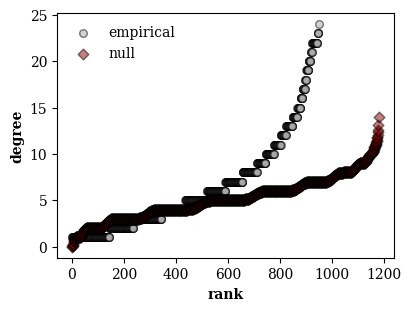

In [260]:
fig, ax = plt.subplots(figsize=(4,3), layout='constrained')

ax.scatter(np.arange(1, len(degdist_before)+1), sorted(degdist_before), s=30, c='darkgray', edgecolors='k', alpha=0.5)
ax.scatter(np.arange(1, len(null_degdist_before)+1), sorted(null_degdist_before), s=30, c='darkred', edgecolors='k', alpha=0.5, marker='D')

plt.ylabel('degree', fontweight='bold')
plt.xlabel('rank', fontweight='bold')
plt.legend(['empirical', 'null'], frameon=False)
plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_before_degree_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

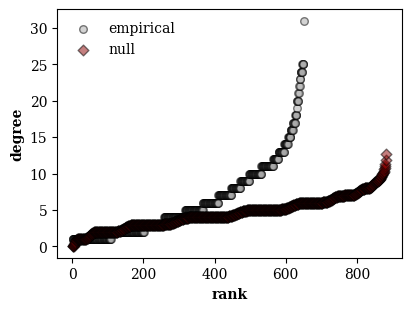

In [261]:
fig, ax = plt.subplots(figsize=(4,3), layout='constrained')

ax.scatter(np.arange(1, len(degdist_after)+1), sorted(degdist_after), s=30, c='darkgray', edgecolors='k', alpha=0.5)
ax.scatter(np.arange(1, len(null_degdist_after)+1), sorted(null_degdist_after), s=30, c='darkred', edgecolors='k', alpha=0.5, marker='D')

plt.ylabel('degree', fontweight='bold')
plt.xlabel('rank', fontweight='bold')
plt.legend(['empirical', 'null'], frameon=False)
plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_after_degree_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

In [262]:
freq_dict_before = dict(Counter(degdist_before))
freq_dict_before_null = dict(Counter(null_degdist_before))

freq_dict_after = dict(Counter(degdist_after))
freq_dict_after_null = dict(Counter(null_degdist_after))

Power law

In [263]:
# Before

y_before = np.asarray(list(freq_dict_before.values()))
x_before = np.asarray(list(freq_dict_before.keys()))

log_x_before = np.log10(x_before)
log_y_before = np.log10(y_before)

y_before_null = list(freq_dict_before_null.values())
x_before_null = list(freq_dict_before_null.keys())

log_x_before_null = np.log10(x_before_null)
log_y_before_null = np.log10(y_before_null)


# After

y_after = np.asarray(list(freq_dict_after.values()))
x_after = np.asarray(list(freq_dict_after.keys()))

log_x_after = np.log10(x_after)
log_y_after = np.log10(y_after)

y_after_null = list(freq_dict_after_null.values())
x_after_null = list(freq_dict_after_null.keys())

log_x_after_null = np.log10(x_after_null)
log_y_after_null = np.log10(y_after_null)

Before: -1.3007359039332536 9.217932885117011e-08
Before Null: -0.009344305936528359 0.7485126651112882
After: -1.4741951127257076 1.8811865491820436e-09
After Null: -0.0183380994475673 0.4910956448927909


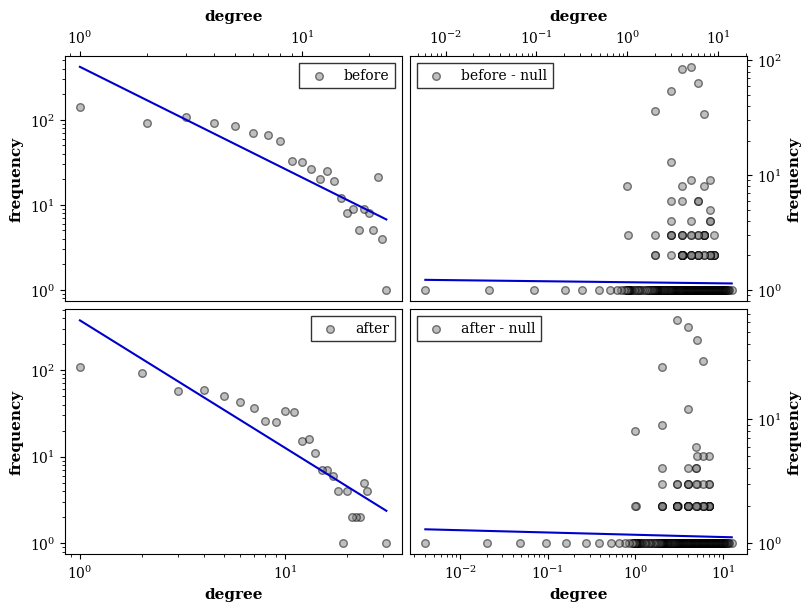

In [264]:
fig, axes = plt.subplots(2,2,figsize=(8,6),layout='constrained')

# Before

axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')

# axes[0,0].invert_yaxis()
axes[0,0].xaxis.tick_top()

axes[0,0].scatter(x_before, y_before, s=30, c='gray', alpha=0.5, edgecolors='k')

m,b,rvalue,pvalue, stderr = linregress(log_x_before, log_y_before)
print('Before:', m, pvalue)

y_pred = b + m*log_x_before

axes[0,0].plot(10**log_x_before, 10**y_pred, 'mediumblue')
axes[0,0].legend(['before'], frameon=True, fancybox=False, edgecolor='k', loc='upper right')

axes[0,0].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[0,0].set_title('degree', fontsize=11, fontweight='bold')

# Before - null

axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')

axes[0,1].xaxis.tick_top()
axes[0,1].yaxis.tick_right()
axes[0,1].yaxis.set_label_position("right")

axes[0,1].scatter(x_before_null, y_before_null, s=30, c='gray', alpha=0.5, edgecolors='k')

m,b,rvalue,pvalue, stderr = linregress(log_x_before_null, log_y_before_null)
print('Before Null:', m, pvalue)

y_pred = b + m*log_x_before_null

axes[0,1].plot(10**log_x_before_null, 10**y_pred, 'mediumblue')
axes[0,1].legend(['before - null'], frameon=True, fancybox=False, edgecolor='k', loc='upper left')

axes[0,1].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[0,1].set_title('degree', fontsize=11, fontweight='bold')


# After

axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')

axes[1,0].scatter(x_after, y_after, s=30, c='gray', alpha=0.5, edgecolors='k')

m,b,rvalue,pvalue, stderr = linregress(log_x_after, log_y_after)
print('After:', m, pvalue)

y_pred = b + m*log_x_after

axes[1,0].plot(10**log_x_after, 10**y_pred, 'mediumblue')
axes[1,0].legend(['after'], frameon=True, fancybox=False, edgecolor='k', loc='upper right')

axes[1,0].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[1,0].set_xlabel('degree', fontsize=11, fontweight='bold')

# After - null

axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')

axes[1,1].yaxis.tick_right()
axes[1,1].yaxis.set_label_position("right")

axes[1,1].scatter(x_after_null, y_after_null, s=30, c='gray', alpha=0.5, edgecolors='k')

m,b,rvalue,pvalue, stderr = linregress(log_x_after_null, log_y_after_null)
print('After Null:', m, pvalue)

y_pred = b + m*log_x_after_null

axes[1,1].plot(10**log_x_after_null, 10**y_pred, 'mediumblue')
axes[1,1].legend(['after - null'], frameon=True, fancybox=False, edgecolor='k', loc='upper left')

axes[1,1].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[1,1].set_xlabel('degree', fontsize=11, fontweight='bold')

plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_degree_distribution_powerlaw.png', dpi=300, bbox_inches='tight')
plt.show()